# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Transfer learning

In the previous notebook we have trained our own CNN and we got a certain performance. Let's see how hard it is to match that performance with transfer learning.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up

The following cells make sure that your environment is setup correctly and check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [1]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

In [2]:
from src.helpers import setup_env

setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 1: Create transfer learning architecture

In [6]:
!pytest -vv src/transfer.py

============================= test session starts =============================
platform win32 -- Python 3.10.13, pytest-7.4.2, pluggy-1.3.0 -- C:\Users\Medhat\Anaconda3\envs\torch\python.exe
cachedir: .pytest_cache
rootdir: C:\Dev\ai\udacity\LandmarkClassifier
plugins: anyio-4.0.0
collecting ... collected 1 item

src/transfer.py::test_get_model_transfer_learning PASSED                 [100%]

============================== warnings summary ===============================
..\..\..\..\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:242
  C:\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:242: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
    interpolation: int = Image.BILINEAR,

..\..\..\..\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:286
  C:\Users\Medhat\Anaconda3\envs\t

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Train, validation and test

Let's train our transfer learning model! Let's start defining the hyperparameters:

In [8]:
batch_size = 64     # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2    # fraction of the training data to reserve for validation
n_epochs = 50       # number of epochs for training
n_classes = 50      # number of classes. Do not change this
lr = 1e-3           # Learning rate for SGD (or Adam)
opt = 'sgd'         # optimizer. 'sgd' or 'adam'
weight_decay = 1e-4 # l2 regularization. Increase this to combat overfitting
momentum = 0.5

In [17]:
from importlib import reload
import src.data as data
import src.transfer as transfer
import src.train as train
import src.optimization as optimization

reload(data)
reload(transfer)
reload(train)
reload(optimization)

<module 'src.optimization' from 'C:\\Dev\\ai\\udacity\\LandmarkClassifier\\src\\optimization.py'>

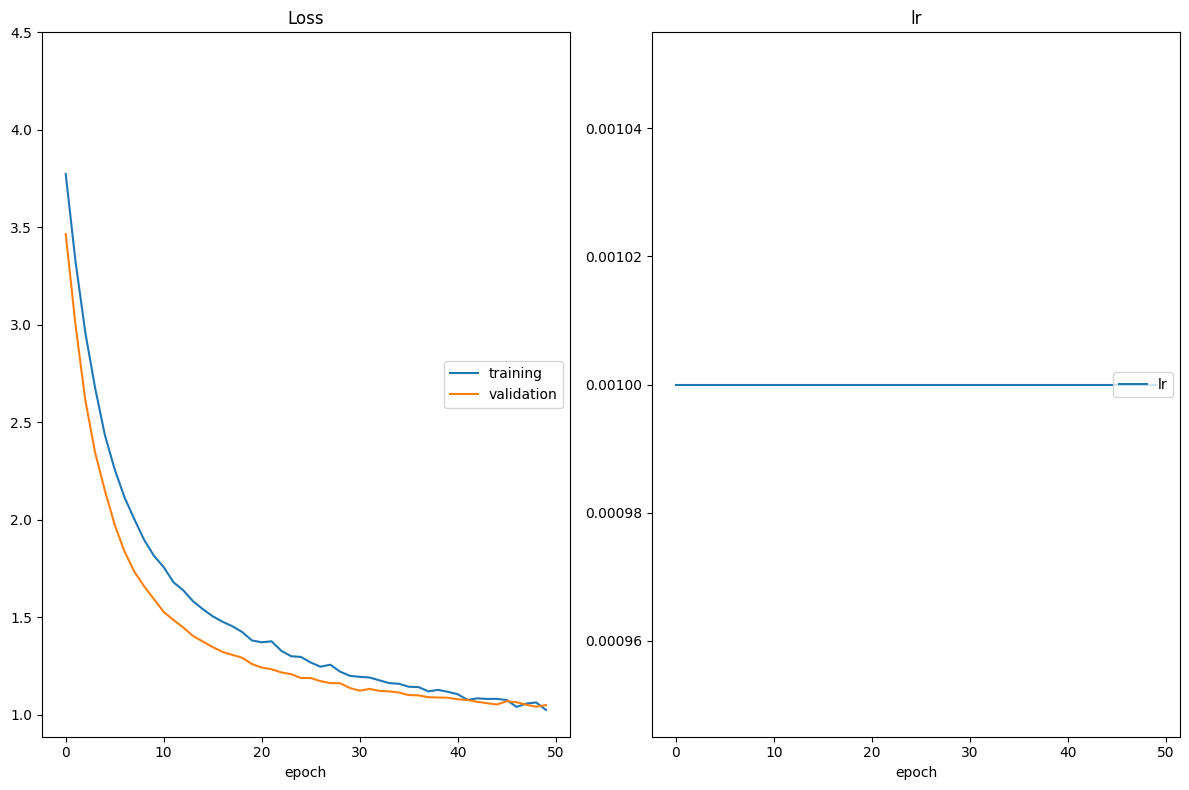

In [18]:
from src.data import get_data_loaders
from src.transfer import get_model_transfer_learning
from src.train import optimize
from src.optimization import get_optimizer, get_loss

model_transfer = get_model_transfer_learning(model_name="resnet50", n_classes=n_classes)

# Train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model=model_transfer, 
    optimizer=opt, 
    learning_rate=lr, 
    momentum=momentum, 
    weight_decay=weight_decay
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True,
    experiment_name="transfer learning - resnet50"
)

In [19]:
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("resnet50", n_classes=n_classes)
# Load saved weights
model_transfer.load_state_dict(torch.load('checkpoints/model_transfer.pt'))

one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:07<00:00,  2.66it/s]

Test Loss: 0.894706


Test Accuracy: 78% (980/1250)


0.8947056144475937

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Export using torchscript

Now, just like we did with our original model, we export the best fit model using torchscript so that it can be used in our application:

In [22]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std

# First let's get the class names from our data loaders
class_names = data_loaders['train'].dataset.classes

# Then let's move the model to the cpu
model_transfer = model_transfer.cpu()

# load the weights
model_transfer.load_state_dict(torch.load("checkpoints/model_transfer.pt", map_location="cpu"))

# Wrap our model using predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(
    model=model_transfer,
    class_names=class_names,
    mean=mean, std=std
)

# export the model
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

Reusing cached mean and std


Testing: 100%|██████████████████████████████| 1250/1250 [03:19<00:00,  6.26it/s]


Accuracy: 0.7704


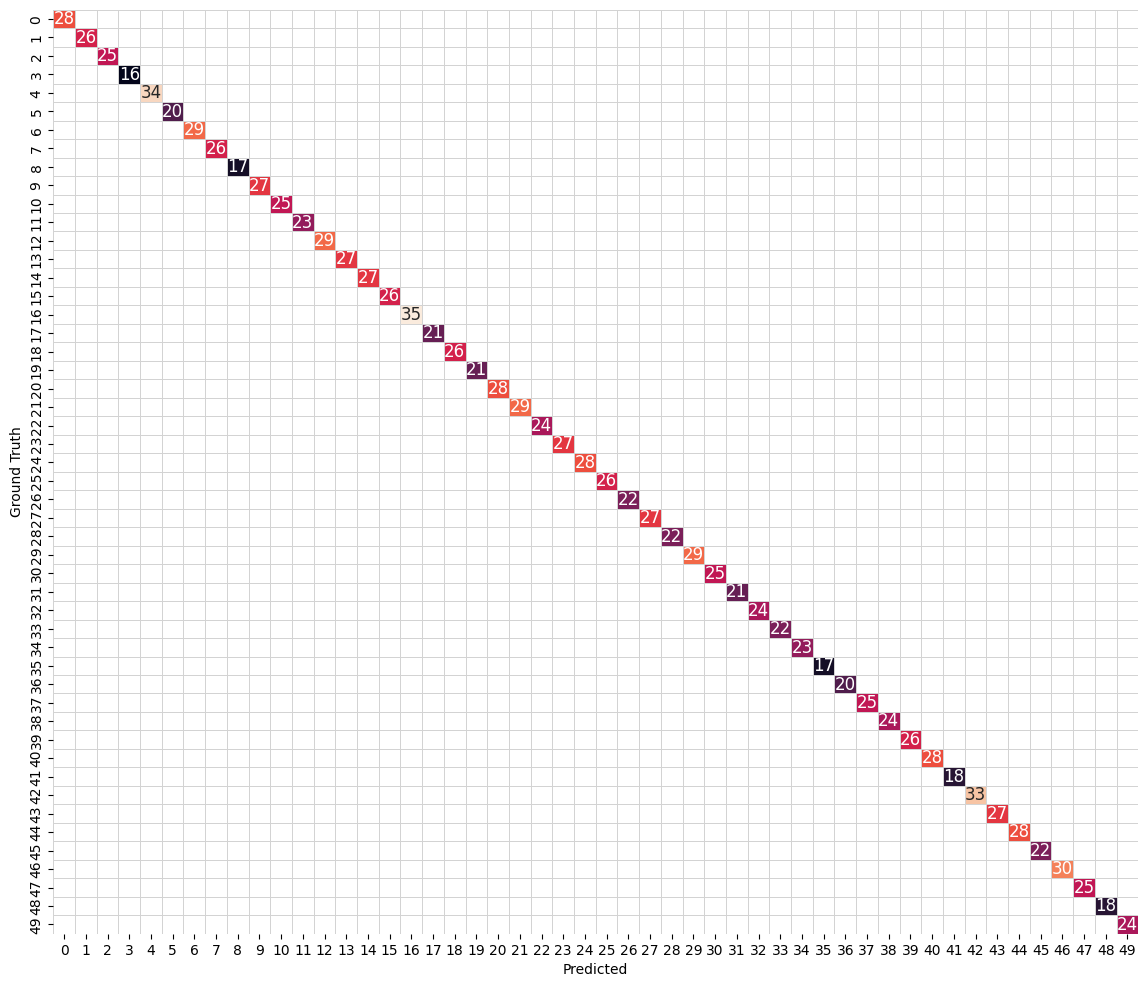

In [25]:
import torch
from src.predictor import predictor_test
from src.helpers import plot_confusion_matrix

model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

pred, truth, _ = predictor_test(test_dataloader=data_loaders['test'], model_reloaded=model_reloaded)

plot_confusion_matrix(pred, truth)

In [26]:
type(model_reloaded)

torch.jit._script.RecursiveScriptModule